# <span style="color:blue;"> Algorithme de détection automatique de faux billets</span>

## Importer des librairies et le fichier csv

In [1]:
# Importer les librairies
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from Functions import graph_box_plots, backward_selected, backward_selected_log_reg
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_percentage_error, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# <span style="color:blue;">La préparation et le nettoyage</span>

### La préparation

In [2]:
# Importer le fichier
billets = pd.read_csv('billets.csv', sep=';')

Ici, je vais vérifier le shape et voir le head du dataframe. Puis, je vais vérifier le type de chaque variable.

In [3]:
# Vérifier le shape
billets.shape

(1500, 7)

In [4]:
# Vérifier le head
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [5]:
# Vérifier les types de données
billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

### Valeurs manquantes

In [6]:
# Chercher des valeurs nulles
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il existe 37 valeurs nulles. Je vais utiliser une régression linéaire pour imputer les valeurs manquantes, comme l'exigent les directives du projet Openclassrooms.

### La numerisation - Remplacer les valeurs "True" et 'False' par 1 et 0  

In [7]:
# Vérifier s'il y a seulement deux valeurs pour la colonne 'is_genuine'
billets['is_genuine'].unique()

array([ True, False])

In [8]:
# Remplacez Vrai et Faux par 0 et 1
billets['is_genuine'] = billets['is_genuine'].replace(False, 0)
billets['is_genuine'] = billets['is_genuine'].replace(True, 1)
billets['is_genuine'] = billets['is_genuine'].astype('int')

### Chercher des valeurs aberrantes

In [9]:
#Créer un dataframe avec seulement les vrais billets
vrais_billets = billets.loc[billets['is_genuine']==1]

#Créer un dataframe avec seulement les faux billets
faux_billets = billets.loc[billets['is_genuine']==0]

#Voir les statistiques pour les vrais et les faux billets
print("Valeurs pour les vrais billets")
display(vrais_billets.describe())
print('--------------------------------------------------------------------')
print("Valeurs pour les faux billets")
display(faux_billets.describe())

Valeurs pour les vrais billets


is_genuine     diagonal  height_left  height_right  margin_low  \
count      1000.0  1000.000000  1000.000000    1000.00000  971.000000   
mean          1.0   171.987080   103.949130     103.80865    4.116097   
std           0.0     0.300441     0.300231       0.29157    0.319124   
min           1.0   171.040000   103.140000     102.82000    2.980000   
25%           1.0   171.790000   103.740000     103.61000    3.905000   
50%           1.0   171.990000   103.950000     103.81000    4.110000   
75%           1.0   172.200000   104.140000     104.00000    4.340000   
max           1.0   172.920000   104.860000     104.95000    5.040000   

        margin_up       length  
count  1000.00000  1000.000000  
mean      3.05213   113.202430  
std       0.18634     0.359552  
min       2.27000   111.760000  
25%       2.93000   112.950000  
50%       3.05000   113.205000  
75%       3.18000   113.460000  
max       3.74000   114.440000

--------------------------------------------------------------------
Valeurs pour les faux billets


is_genuine    diagonal  height_left  height_right  margin_low  \
count       500.0  500.000000   500.000000    500.000000  492.000000   
mean          0.0  171.901160   104.190340    104.143620    5.215935   
std           0.0    0.306861     0.223758      0.270878    0.553531   
min           0.0  171.040000   103.510000    103.430000    3.820000   
25%           0.0  171.690000   104.040000    103.950000    4.840000   
50%           0.0  171.910000   104.180000    104.160000    5.190000   
75%           0.0  172.092500   104.332500    104.320000    5.592500   
max           0.0  173.010000   104.880000    104.950000    6.900000   

        margin_up      length  
count  500.000000  500.000000  
mean     3.350160  111.630640  
std      0.180498    0.615543  
min      2.920000  109.490000  
25%      3.220000  111.200000  
50%      3.350000  111.630000  
75%      3.472500  112.030000  
max      3.910000  113.850000

Bien qu'il existe des variables avec des tailles maximales élevées ou des tailles minimales petites, les valeurs ne semblent pas être des valeurs aberrantes.

Les écarts types des faux tickets pour margin_low et length sont beaucoup plus grands que pour les vrais.

# <span style="color:blue;">Analyse Déscriptive</span>



### Compte du vrais et du faux billets

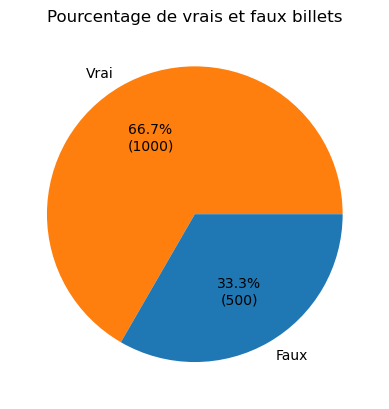

In [10]:
#Visualiser le pourcentage de vrais billets et de faux billets
counts = billets['is_genuine'].value_counts()
labels = ['Vrai', 'Faux']
colors=['tab:orange', 'tab:blue']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

plt.pie(counts, labels=labels, colors=colors, autopct=autopct_format(counts))
plt.title("Pourcentage de vrais et faux billets")
plt.show()

- Vrais billets : 1000
- Faux billets : 500

### Boxplots pour chaque variable prédictive par 'is_genuine'

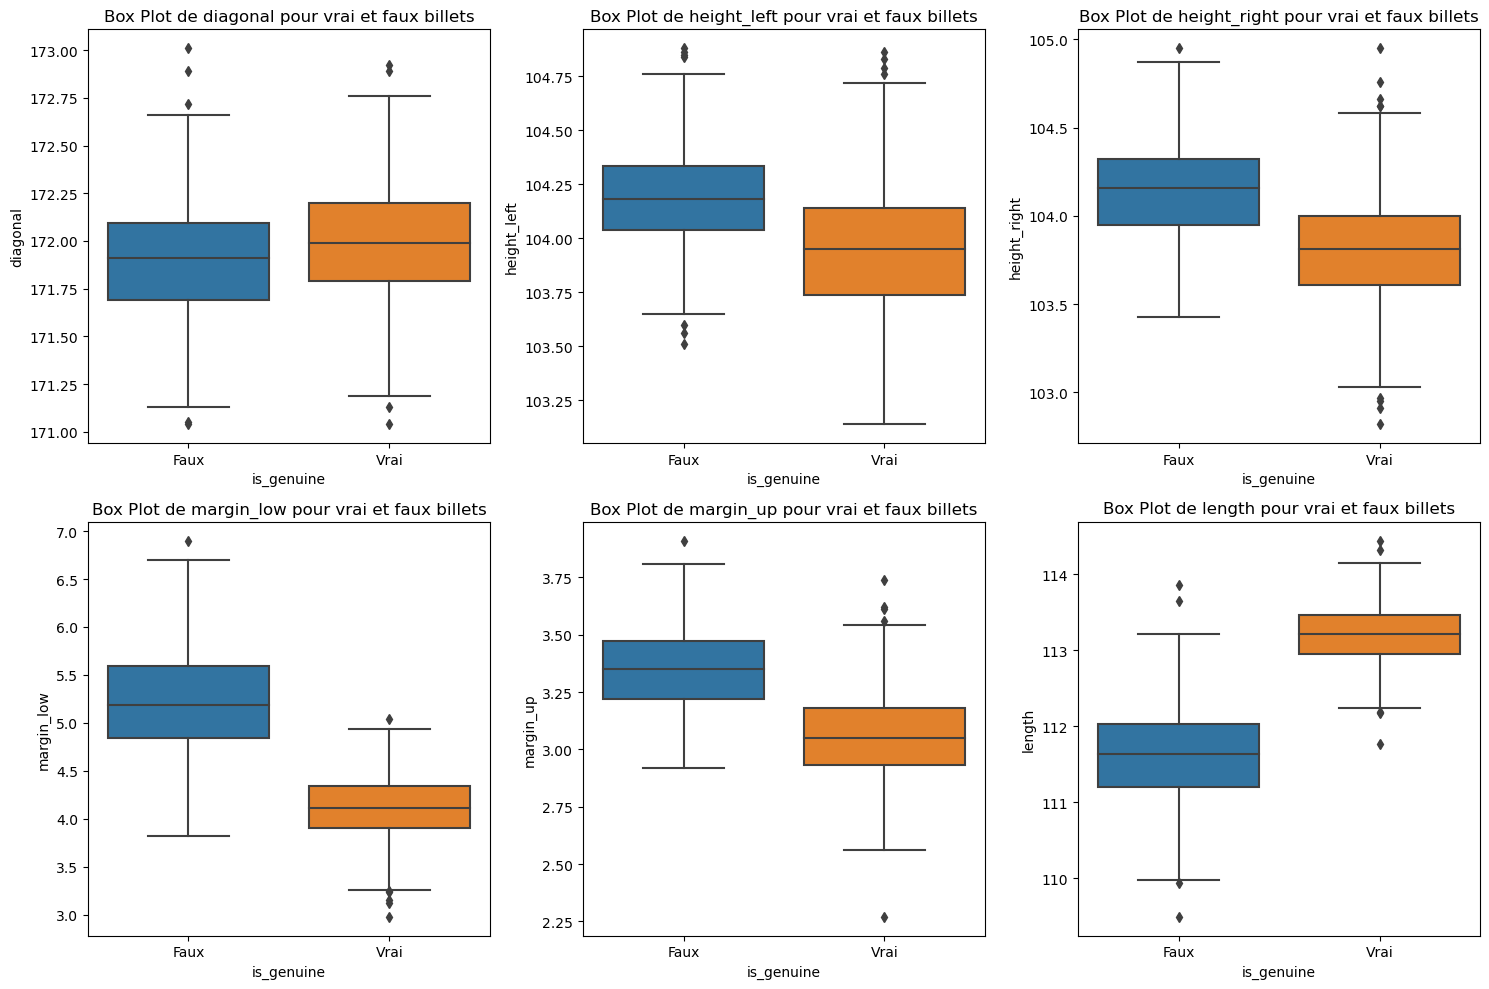

In [11]:
#Visualiser la répartition des dimensions des billets
columns = ['diagonal','height_left','height_right','margin_low','margin_up','length']

graph_box_plots(billets, columns)

#### Comparaison des dimensions des vrais et faux billets
- Les dimensions de « diagonal » sont très similaires
- Les dimensions de « height_left » et « height_right » sont également relativement similaires.
- En revanche, les dimensions pour « length » et «margin_low» sont très différentes pour les vrais et les faux billets. Cela suggère un lien entre la réalité d’un billet et ces variables.
- Les dimensions de « margin_up » sont aussi relativement distinctes pour les vrais et les faux billets.

### Matrice de corrélation

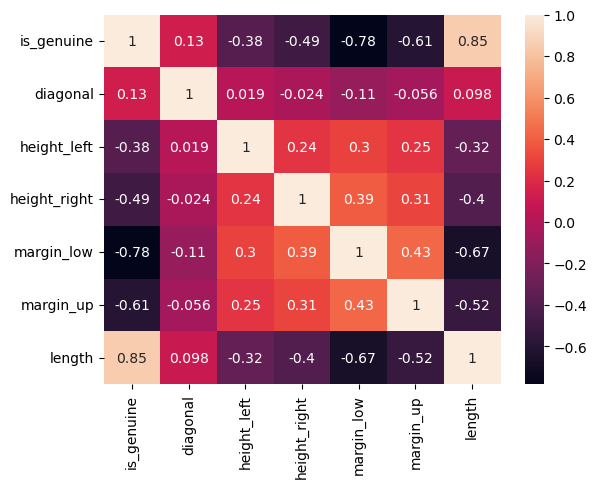

In [12]:
#Créer une matrice de corrélation
correlation_matrix = billets.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

Une matrice de corrélation nous indique dans quelle mesure chaque variable est corrélée avec les autres variables de la base de données.

#### Length, margin_low et margin_up sont les 3 variables les plus corrélé avec is_genuine.
- length - corrélation positive de 0,85 - les billets avec une longeur plus grand sont plus susceptibles d'être vrais.
- margin_low - corrélation négative de -0,78 - les billets avec une marge en bas plus grande sont plus susceptibles d'être faux. 
- margin_up - corrélation négative de -0,61 - les billets avec une marge en haut plus grande sont plus susceptibles d'être faux.
#### Diagonal est la variable la moins corrélée avec is_genuine
- diagonal - corrélation négative de -0,13

### Pairplot

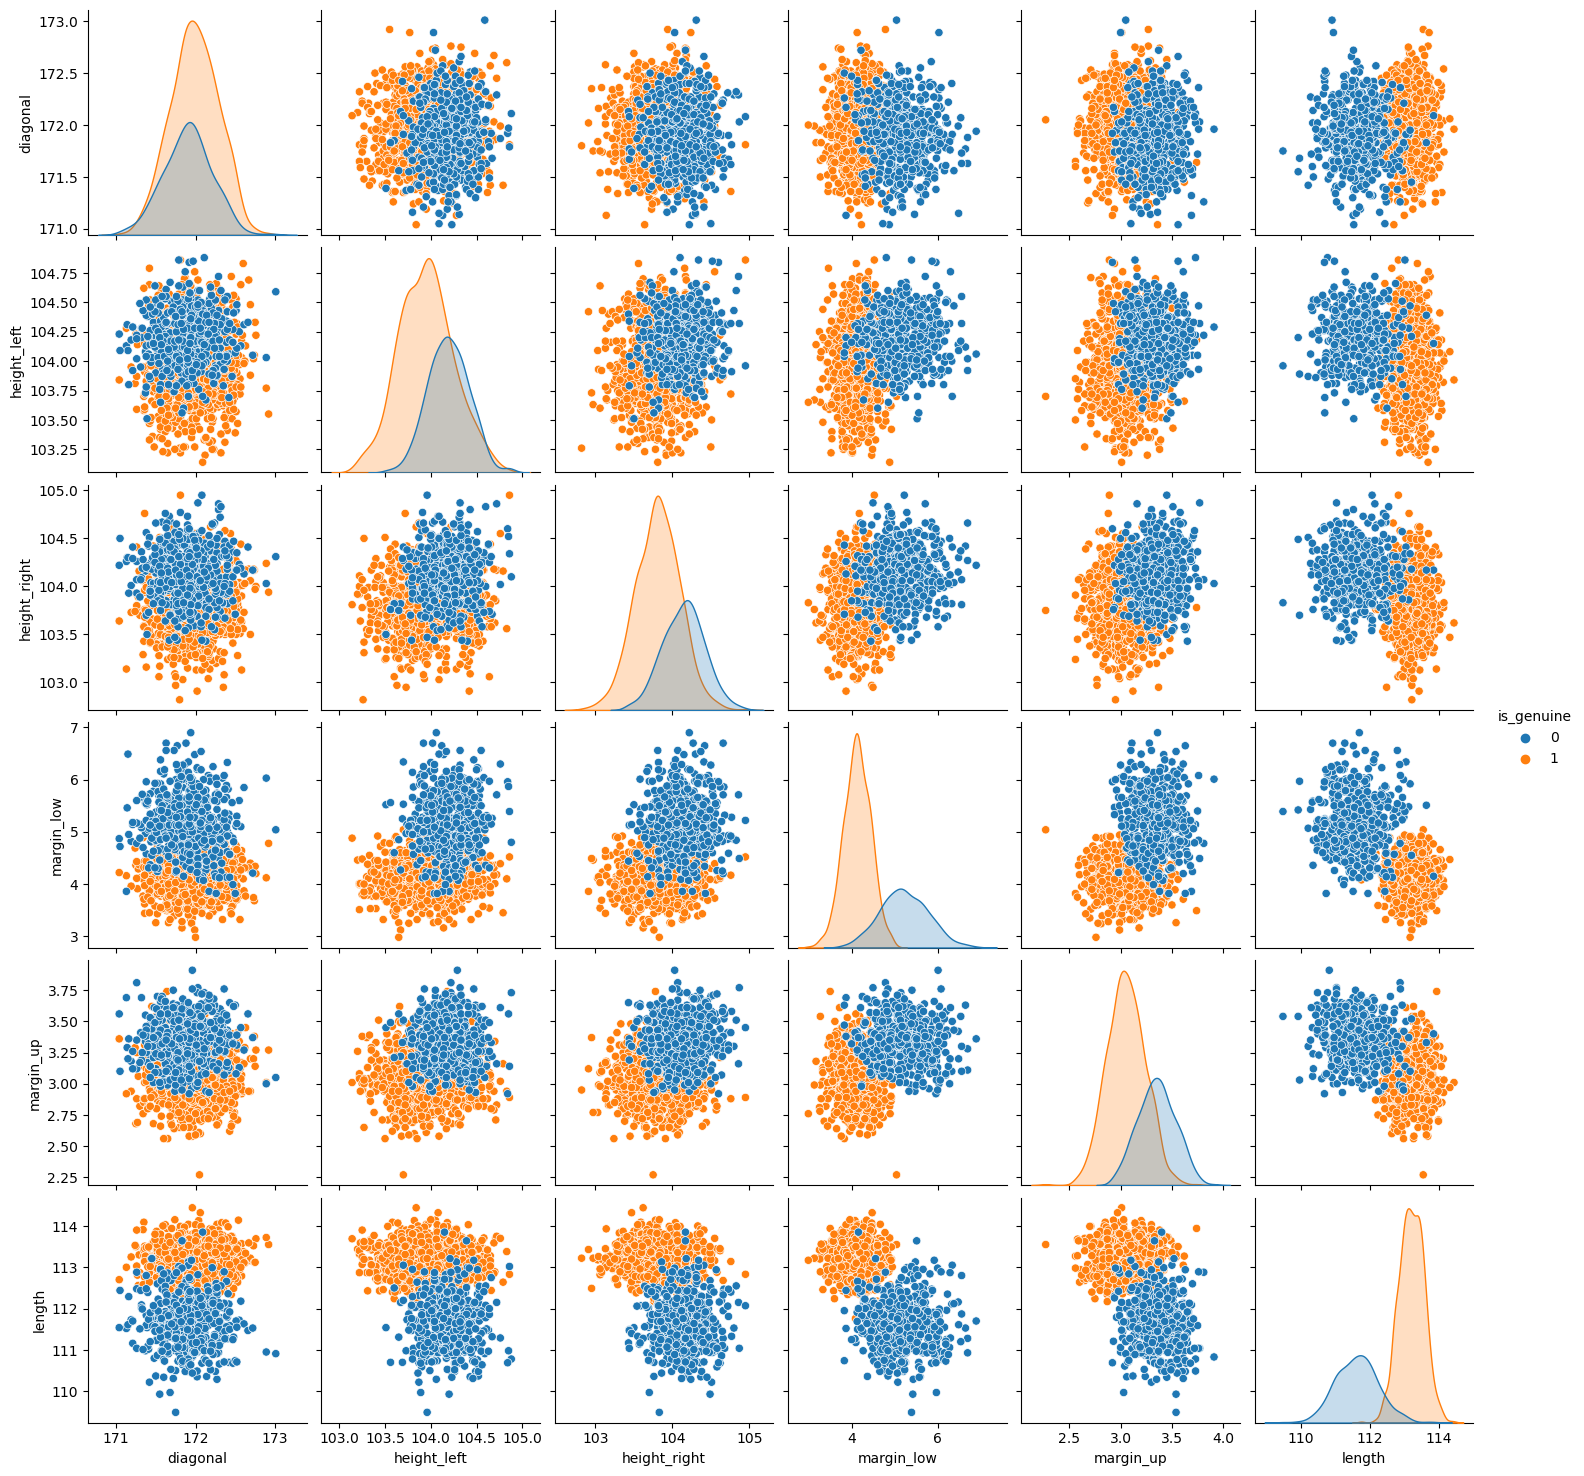

In [13]:
#Créer un pairplot
sns.pairplot(billets, hue='is_genuine')

Un pairplot visualise la relation entre chaque variable dans un dataframe.

#### Graphiques diagonales
Les graphiques diagonales montre la distribution de chaque variable pour les faux billets (0), et les vrais billets (1)
- Length et margin_up ont des distinctions claires entre les vrais et les faux billets. Cela suggère que ce seraient de bonnes variables prédictives
- Il n'y a pas des distinctions claires entre les vrais et les faux billets pour "diagonal". Les distinctions pour height_left et height_right ne sont pas claires non plus. 
#### Scatterplots
- Les scatterplots avec length comme une variable ont des clusters assez bien séparé, surtout length et margin_low. Cela suggérée que length pourrait contribuer de manière significative à déterminer quels billets sont vrais et quels billets sont faux. 
- Le scatterplot avec margin_low et margin_up ont des clusters qui sont aussi assez bien séparés.

### Résultats

Il semble y avoir une relation entre « is_genuine » et « length », « margin_low » et « margin_up ».

D'un autre côté, « diagonal » ne semble pas avoir de forte corrélation avec « is_genuine ». « height_left » et « height_right » semblent également avoir des corrélations relativement faibles avec « is_genuine ».

# <span style="color:blue;"> Valeurs Manquantes </span>

In [14]:
print("Il y a",billets.margin_low.isna().sum(),"valeurs manquantes dans la colonne 'margin_low'")

Il y a 37 valeurs manquantes dans la colonne 'margin_low'


Il existe plusieurs façons de gérer les valeurs manquantes :
#### 'Ignorer et supprimer tous les échantillons pour lesquels cette valeur manque'
- Supprimer les billets avec des valeurs manquantes pour « margin_low » réduirait la taille de notre ensemble de données, et comme toutes les autres variables des billets ont des valeurs, cela semble être un gaspillage de supprimer ces individus.

#### 'Remplacer les valeurs manquantes par une valeur spécifique qui indique que la valeur n'est pas disponible. Par exemple -1 ou 0 pour des nombres ou None pour une catégorie.'
- Remplacer les valeurs manquantes par une valeur spécifique (par exemple 0 ou -1) peut affecter négativement les modèles que je créerai ultérieurement.

#### 'Inférer les valeurs manquantes à partir des valeurs disponibles ... On peut par exemple prendre la moyenne des valeurs disponibles ou construire une régression linéaire à partir des autres variables.'
- Infère les données manquantes semble être la meilleure façon de procéder. Bien que prendre la moyenne des billets de fruits et des faux billets soit une option rapide et pratique, une approche plus rigoureuse consiste à effectuer une régression linéaire pour trouver les valeurs estimées pour chaque billet de banque.
 (https://openclassrooms.com/fr/courses/8063076-initiez-vous-au-machine-learning/8299343-ameliorez-un-jeu-de-donnees)

## <span style="color:blue;">Régression linéaire</span>

Je vais tester utiliser une régression linéaire afin de trouver des valeurs assez précises

### Séparer les données

In [15]:
# Créér un dataframe sans les billets avec valeurs manquantes
not_na_billets = billets.loc[billets['margin_low'].notnull()]

### Visualiser les coefficients des variables discriminantes

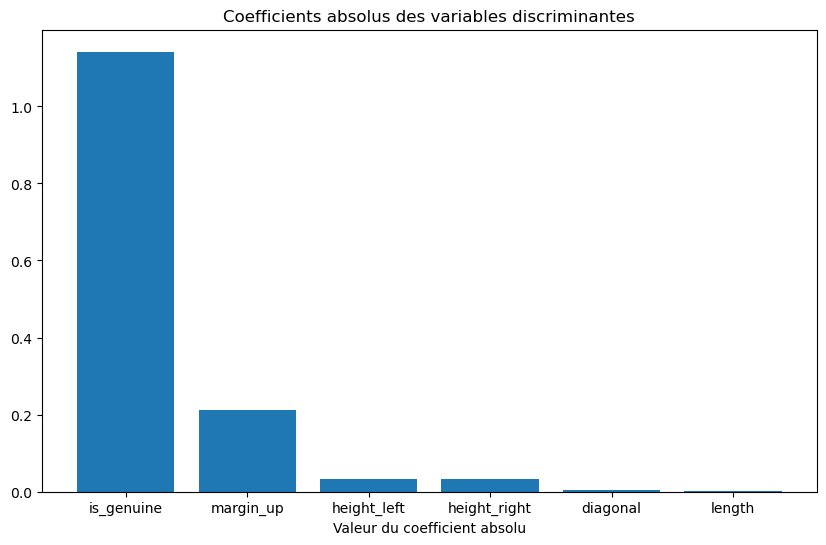

In [16]:
X = not_na_billets.drop(columns='margin_low')
y = not_na_billets.margin_low

# Entrainer le modèle
test_lin_reg = sm.OLS(y, X)
result = test_lin_reg.fit()

# Créer un dataframe avec les coefficients du modèle
coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': result.params})

# Changer les valeurs des coefficients en leurs valeurs absolues
coefficients_df['CoefficientAbs'] = abs(coefficients_df['Coefficient'])

# Trier les variables dans l'ordre décroissant
coefficients_df = coefficients_df.sort_values(by='CoefficientAbs', ascending=False)
coefficients_df = coefficients_df[coefficients_df['Variable'] != 'const']

# Visualiser les valeurs absolues des variables
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Variable'], coefficients_df['CoefficientAbs'])
plt.xlabel('Valeur du coefficient absolu')
plt.title('Coefficients absolus des variables discriminantes')
plt.show()

Ce graphique montre que la variable discriminante 'is_genuine' influence de loin le plus 'margin_low'. « Margin_up » a une faible influence et les autres variables ont des niveaux d'influence très faibles.

### Retirer les variables non significatives

In [17]:
# Trouver les variables les plus pertinentes pour le modèle
columns = ['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']
reg_backward = backward_selected(not_na_billets[columns], 'margin_low')

_______________________________
margin_low ~ is_genuine + diagonal + height_left + margin_up + height_right + length + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ is_genuine + diagonal + height_left + margin_up + height_right + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ is_genuine + height_left + margin_up + height_right + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ is_genuine + height_left + margin_up + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

Cette fonction a identifié le meilleur modèle est ce que nous avons vu avec le graphique ci-dessus - un modèle avec les deux variables prédictives « is_genuine » et « margin_up ».

#### Le modèle est statistiquement significatif
Les p-valeurs sont inférieures à 5 % (1.24e-304). On rejette donc l'hypothèse selon laquelle le paramètre est égal à 0 - 

#### La valeur R-squared est de 0,617 
Le modèle explique environ 61,7 % de la variabilité de 'margin_low'.

#### Coefficients
is_genuine: -1,1632 - chaque augmentation d'une unité dans « is_genuine » entraîne une diminution d'environ 1,1632 unités dans « margin_low ». Cela suggère que les vrais billets de banque ont des marges inférieures à celles des faux.

margin_up: -0,2119 - chaque augmentation d'une unité dans « margin_up » entraîne une diminution d'environ 0,2119 unités dans « margin_low ». Cela suggère qu’une marge inférieure plus grande est associée à une marge supérieure plus grande.

##  Analyse des resultats

In [18]:
# Definir X et y basé sur le modèle ci-dessus
X = not_na_billets[['is_genuine', 'margin_up']]
X = sm.add_constant(X)
y = not_na_billets['margin_low']

In [19]:
# Entrainer le modèle
lin_reg_model = sm.OLS(y, X)

# Fit le modèle
lin_reg_model = lin_reg_model.fit()

In [20]:
# Définir le niveau de signification (alpha) à 5 %
alpha = 0.05

# Nombre de billets
n=not_na_billets.shape[0]

p = 3

#Créer un nouveau dataframe pour l'analyse
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['obs'] = analyses['obs'].astype('float')

###  La distance de Cook

La distance de Cook combine des informations sur les résidus et l'effet des leviers pour mesurer l'influence de chaque observation sur les prédictions du modèle. Je vais l'utiliser pour identifier les valeurs aberrantes et les supprimer afin de voir si cela peut aider à améliorer la régression linéaire.

In [21]:
# Trouver la distance de Cook
influence = lin_reg_model.get_influence().summary_frame()

# Ajouter la distance au dataframe
analyses['dcooks'] = influence['cooks_d']

# Calculer le seuil
seuil_dcook = 4/(n-p)

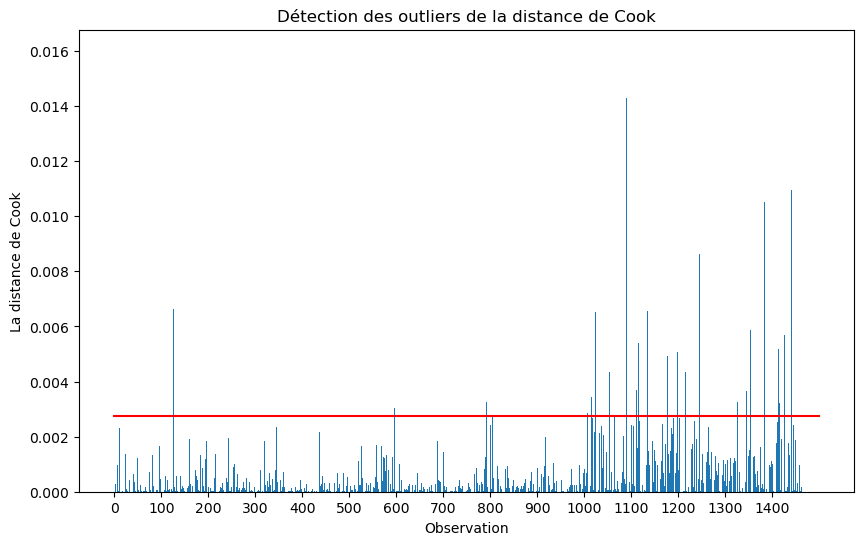

Il y a 93 valeurs qui dépassent le seuil de la distance de Cook.
Il y a 79 faux billets qui sont des outliers et il y a 14 vrais billets.


In [22]:
# Visualiser la distance de cook et les outliers
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=100))
plt.title("Détection des outliers de la distance de Cook")
plt.xlabel('Observation')
plt.ylabel('La distance de Cook')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

#Trouver le nombre des valeurs aberrantes
outliers_cooks = analyses.loc[analyses['dcooks'] > seuil_dcook, :]
print('Il y a', outliers_cooks['dcooks'].count(), 'valeurs qui dépassent le seuil de la distance de Cook.')
outliers= pd.merge(not_na_billets, outliers_cooks, left_index=True, right_index=True).drop(columns =['obs', 'dcooks'])
print('Il y a', outliers.loc[outliers['is_genuine']==0, 'is_genuine'].count(), 'faux billets qui sont des outliers et il y a', outliers.loc[outliers['is_genuine']==1, 'is_genuine'].count(), 'vrais billets.')

Les valeurs aberrantes concernant les faux billets ne sont pas surprenantes, car certains faux billets peuvent être moins réalistes que d’autres. Cependant, les valeurs aberrantes concernant les vrais billets sont plus surprenantes.

In [23]:
#Trouver les vrais billets qui sont des outliers selon la Distance de Cook
true_outliers = outliers.loc[outliers['is_genuine']==1,]
print('----------------------------------------------------------------------------')
print('Outliers - Vrais billets')
display(true_outliers.describe())

#Trouver les vrais billets qui ne sont pas des outliers selon la Distance de Cook
print('----------------------------------------------------------------------------')
print("Pas d'outliers - Vrais billets")
true_not_outliers = not_na_billets.drop(true_outliers.index)
display(true_not_outliers.describe())

----------------------------------------------------------------------------
Outliers - Vrais billets


is_genuine    diagonal  height_left  height_right  margin_low  \
count        14.0   14.000000    14.000000     14.000000   14.000000   
mean          1.0  171.864286   103.974286    103.898571    3.875714   
std           0.0    0.264334     0.216145      0.265094    0.751713   
min           1.0  171.340000   103.650000    103.290000    2.980000   
25%           1.0  171.752500   103.777500    103.785000    3.282500   
50%           1.0  171.925000   104.010000    103.885000    3.505000   
75%           1.0  171.960000   104.177500    104.012500    4.727500   
max           1.0  172.450000   104.250000    104.390000    5.040000   

       margin_up      length  
count  14.000000   14.000000  
mean    2.978571  113.291429  
std     0.445557    0.374060  
min     2.270000  112.580000  
25%     2.702500  113.177500  
50%     2.770000  113.280000  
75%     3.440000  113.542500  
max     3.740000  113.940000

----------------------------------------------------------------------------
Pas d'outliers - Vrais billets


is_genuine     diagonal  height_left  height_right   margin_low  \
count  1449.000000  1449.000000  1449.000000   1449.000000  1449.000000   
mean      0.660455   171.960110   104.031884    103.921698     4.491863   
std       0.473718     0.305763     0.300300      0.324767     0.660454   
min       0.000000   171.040000   103.140000    102.910000     3.120000   
25%       0.000000   171.750000   103.830000    103.710000     4.020000   
50%       1.000000   171.960000   104.040000    103.920000     4.320000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up       length  
count  1449.000000  1449.000000  
mean      3.154769   112.668799  
std       0.228068     0.874597  
min       2.560000   109.490000  
25%       2.990000   112.010000  
50%       3.140000   112.960000  
75%       3.310000   113.330000  
max       3.910000   114.320000

Étant donné la différence relative entre les valeurs aberrantes des vrais billets et les autres vrais billets, je vais supprimer les vrais billets qui sont des outliers.

In [24]:
#Supprimer les valeurs aberrantes
not_na_billets_2 = not_na_billets[['margin_low', 'is_genuine', 'margin_up']].drop(true_outliers.index)

#Vérifier les resultats de la régression
lin_reg_model_2 = smf.ols('margin_low~margin_up+is_genuine', data=not_na_billets_2).fit()
print(lin_reg_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1192.
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.29e-306
Time:                        11:19:47   Log-Likelihood:                -748.65
No. Observations:                1449   AIC:                             1503.
Df Residuals:                    1446   BIC:                             1519.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0124      0.200     29.995      0.0

#### Le modèle est statistiquement significatif
Les p-valeurs sont inférieures à 5 % (0). On rejette donc l'hypothèse selon laquelle le paramètre est égal à 0 - le modèle est statistiquement significatif.

#### La valeur R-squared est 0.623 au lieu de 0,617 
Le modèle explique environ 62,3 % de la variabilité de 'margin_low'.

#### Coefficients
is_genuine: -1,1671 - chaque augmentation d'une unité dans « is_genuine » entraîne une diminution d'environ 1,1671 unités dans « margin_low ». Cela suggère que les vrais billets de banque ont des marges inférieures à celles des faux.

margin_up: -0,2377 - chaque augmentation d'une unité dans « margin_up » entraîne une diminution d'environ 0,2377 unités dans « margin_low ». Cela suggère qu’une marge inférieure plus grande est associée à une marge supérieure plus grande.

#### Je vais donc continuer sur cette voie et poursuivre une analyse plus approfondie.

### Colinéarité des variables

In [25]:
#Vérifier la colinéarité entre les variables et trouver le VIF
variables = lin_reg_model_2.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.6202616626641906, 1.6202616626641901]

- La colinéarité est lorsque deux variables sont trop étroitement corrélées (par exemple, l'âge et les mois depuis né). Généralement, un VIF sous 10 suggère que la corrélation entre les variables prédictives du modèle n'est pas problématique.
- Tous les coefficients sont inferieurs à 10, donc il n'y a pas de problème de colinéarité.

### L’homoscédasticité

L'homoscédasticité est l'hypothèse selon laquelle différents groupes comparés les uns aux autres présentent des variances égales ou similaires.

In [26]:
# Verifier l'homoscédasticité
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(lin_reg_model_2.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.9624406801134338e-39


La p-valeur ici est inférieure à $5$% - je dois rejetter l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

### La normalité des résidus

In [27]:
# Verifier si les données suivre une distribution normale. 
shapiro(lin_reg_model_2.resid)

ShapiroResult(statistic=0.992842435836792, pvalue=1.764379589985765e-06)

#### Statistique = 0,99
- Plus la statistique est proche de 1, plus l'échantillon ressemble à une distribution normale.

#### Valeur P = 1.764e-06
- L'hypothèse de normalité est remise en cause (pvalue = 1.764e-06 < 0.05). Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

## Resultats
- Le test de la colinéarite - validé
- Le test d'homoscedascité - pas validé
- Le test de la normalité des résidus - pas validé

Compte tenu des résultats de cette analyse, ce modèle est une bonne option pour la regression linéaire. 
Je vais l'utilise pour trouver les valeurs manquantes dans la colonne 'margin_low'. 

### Créer les valeurs imputées pour les cellules avec des valeurs manquantes

In [28]:
# Créer un dataframe avec les valeurs des billets avec les valeurs nulles pour 'margin_low' 
na_billets = billets.loc[billets["margin_low"].isna()]

#Prédire les valeurs de 'margin_low' avec les valeurs du dataframe 'valeurs_nulles'
predicted_value = lin_reg_model_2.predict(na_billets)

#Ajouter ces valeurs au l'original dataframe
billets.loc[billets['margin_low'].isnull(), 'margin_low']=predicted_value

# <span style="color:blue;"> Créer un modèle pour determiner si des billets sont vrais ou faux</span>

**La prochaine étape est de créer un modèle afin de déterminer si des billets sont vrais ou sont faux. Je vais utiliser deux types de régression logistique (statsmodel et Scikit-Learn) et k-means et puis comparer l'efficacité des trois modèles.**

## <span style="color:blue;">Les régressions logistiques</span>

In [29]:
# Définir les variables prédictives
X = billets.drop(columns='is_genuine')
y = billets.is_genuine

# Diviser les données en test et en train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <span style="color:blue;">1. Statsmodels - Régression logistique</span>
### Trouver les valeurs les plus pertinentes

Optimization terminated successfully.
         Current function value: 0.026616
         Iterations 12


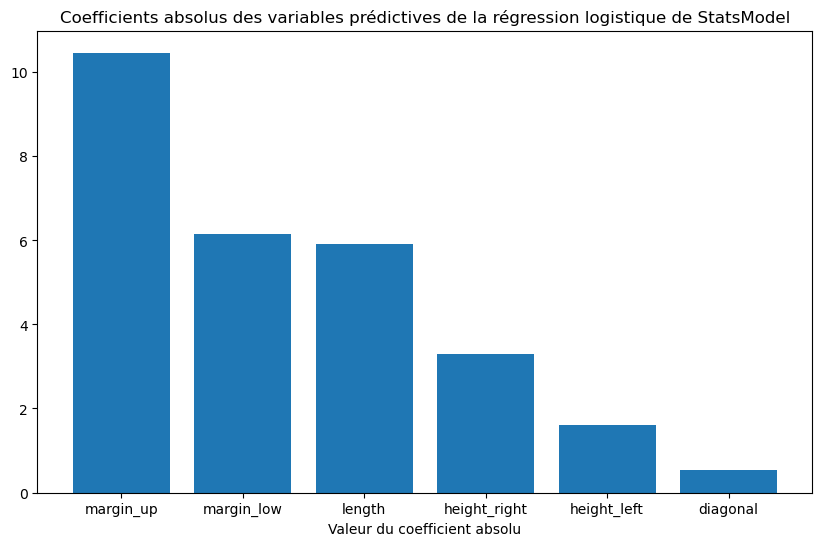

In [30]:
# Entrainer le modèle
test_sm_log_reg = sm.Logit(y, X)
result = test_sm_log_reg.fit()

# Créer un dataframe avec les coefficients du modèle
coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': result.params})

# Changer les valeurs des coefficients en leurs valeurs absolues
coefficients_df['CoefficientAbs'] = abs(coefficients_df['Coefficient'])

# Trier les variables dans l'ordre décroissant
coefficients_df = coefficients_df.sort_values(by='CoefficientAbs', ascending=False)
coefficients_df = coefficients_df[coefficients_df['Variable'] != 'const']

# Visualiser les valeurs absolues des variables
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Variable'], coefficients_df['CoefficientAbs'])
plt.xlabel('Valeur du coefficient absolu')
plt.title('Coefficients absolus des variables prédictives de la régression logistique de StatsModel')
plt.show()

Les variables les plus pertinentes semble d'etre 'margin_up', 'margin_low' et 'length'. Je peux utiliser une fonction afin de vérifier s'ils sont les variables les plus pertinentes pour le modèle. 

In [31]:
# Trouver les variables les plus pertinentes pour le modèle
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
log_reg = backward_selected_log_reg(billets[columns], 'is_genuine')

_______________________________
is_genuine ~ margin_low + diagonal + height_left + margin_up + height_right + length + 1
Optimization terminated successfully.
         Current function value: 0.026324
         Iterations 13
remove diagonal (p-value : 0.813 )

_______________________________
is_genuine ~ margin_low + height_left + margin_up + height_right + length + 1
Optimization terminated successfully.
         Current function value: 0.026343
         Iterations 13
remove height_left (p-value : 0.254 )

_______________________________
is_genuine ~ margin_low + margin_up + height_right + length + 1
Optimization terminated successfully.
         Current function value: 0.026782
         Iterations 13
is the final model !

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1495
Method:                       

Cette fonction a identifié que le meilleur modèle est en fait un modèle avec 4 variables prédictives - 'margin_up', 'height_right', 'margin_low' et 'length'.

#### La valeur du pseudo R-squared est de 0,9579
Le modèle explique environ 95,7 % de la variabilité de 'is_genuine'.

#### Le modèle est statistiquement significatif
Les LLR p-valeurs sont inférieures à 5 % (0.000). 

#### Coefficients
1. margin_up (-10.4098) : Pour chaque augmentation d'une unité de margin_up, la probabilité logarithmique que le billet soit vrai diminue d'environ 10,41. Cela suggère que plus la marge supérieure est grande, moins il est probable qu’elle soit réelle.

2. 'height_right' (-3,3512) : Pour chaque augmentation d'une unité de height_right, la probabilité logarithmique que le billet soit vrai diminue d'environ 3,35. Cela suggère que plus la hauteur de la main droite est grande, moins il est probable que le billet soit réel.
 
3. 'margin_low' (-6,3058) : Pour chaque augmentation d'une unité de margin_low, la probabilité logarithmique que le billet soit vrai diminue d'environ 6,31. Cela suggère que plus la marge inférieure est grande, moins il est probable que le billet soit réel.
 
4. « length » (6.1592) : pour chaque augmentation d'une unité de length, la probabilité logarithmique que le billet soit vrai augmente d'environ 6,16. Cela suggère que plus la marge est faible, plus il est probable que le billet soit réel.

### Définir les variables prédictives du modèle et diviser les données en test et en train

In [32]:
# Définir les variables prédictives
X = billets[['height_right','margin_low','margin_up','length']]
y = billets.is_genuine

# Diviser les données en test et en train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrainer le modèle
sm_log_reg = sm.Logit(y_train, X_train).fit() 

# Faire des prédictions
y_pred = sm_log_reg.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.030209
         Iterations 11


### Accuracy, Précision, Recall et ROC-AUC

Ma prochaine étape est de vérifier l'accuracy, la précision, le recall et le ROC-AUC pour ce modèle. 

In [33]:
# Arrondissez la prédiction au nombre le plus proche (0 ou 1)
prediction = list(map(round, y_pred)) 
  
# Créer une matrice de confusion 
cm = confusion_matrix(y_test, prediction)  

Test accuracy =  0.9933333333333333
Precision : 0.9896
Recall : 1.0000
ROC-AUC score : 0.9909090909090909


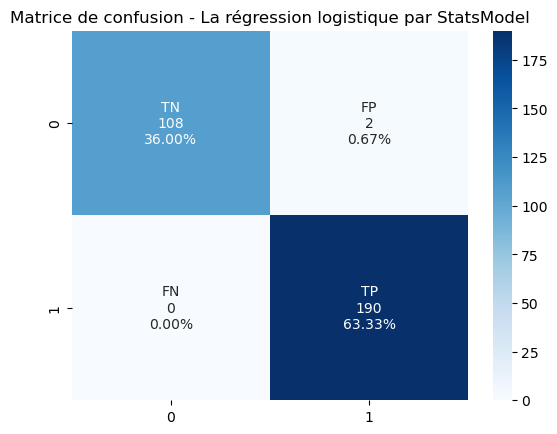

In [34]:
#Calculer précision, recall et ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# Visualiser la matrice de confusion
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Matrice de confusion - La régression logistique par StatsModel')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Test accuracy = ', accuracy_score(y_test, prediction))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

#### Accuracy
- Le modèle est précis à 99,3% de ses prédictions - un excellent niveau de précision

#### Précision
- La précision concerne la proportion de billets qui ont été correctement identifiés comme réels. 
- Dans ce cas, seulement deux billets ont été identifié à tort comme étant réel alors qu’il était faux. Cela signifie que le modèle a une précision de 98,96 %.

#### Recall
- Le recall concerne la proportion de billets correctement identifiés comme faux. 
- Dans ce cas, tous les billets identifiés comme faux étaient en réalité des faux.

#### ROC-AUC
- Plus un score ROC-AUC est proche de 1, mieux c'est. Dans ce cas, le score est 0,99

### Amélioration du modèle - Seuil de séparation des classes

In [35]:
y_prob = sm_log_reg.predict(X_test)

for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred = (y_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print(f'Seuil {threshold} - Nombre de True Negative = {tn}')
    print(f'Seuil {threshold} - Nombre de True Positive = {tp}')
    print(f'Seuil {threshold} - Nombre de False Negative = {fn}')
    print(f'Seuil {threshold} - Nombre de False Positive = {fp}')
    print('------------------------------------------------')

Seuil 0.3 - Nombre de True Negative = 106
Seuil 0.3 - Nombre de True Positive = 190
Seuil 0.3 - Nombre de False Negative = 0
Seuil 0.3 - Nombre de False Positive = 4
------------------------------------------------
Seuil 0.4 - Nombre de True Negative = 106
Seuil 0.4 - Nombre de True Positive = 190
Seuil 0.4 - Nombre de False Negative = 0
Seuil 0.4 - Nombre de False Positive = 4
------------------------------------------------
Seuil 0.5 - Nombre de True Negative = 108
Seuil 0.5 - Nombre de True Positive = 190
Seuil 0.5 - Nombre de False Negative = 0
Seuil 0.5 - Nombre de False Positive = 2
------------------------------------------------
Seuil 0.6 - Nombre de True Negative = 108
Seuil 0.6 - Nombre de True Positive = 189
Seuil 0.6 - Nombre de False Negative = 1
Seuil 0.6 - Nombre de False Positive = 2
------------------------------------------------
Seuil 0.7 - Nombre de True Negative = 110
Seuil 0.7 - Nombre de True Positive = 189
Seuil 0.7 - Nombre de False Negative = 1
Seuil 0.7 - Nom

Test accuracy =  0.9966666666666667
Precision : 1.0000
Recall : 0.9947
ROC-AUC score : 0.9973684210526316


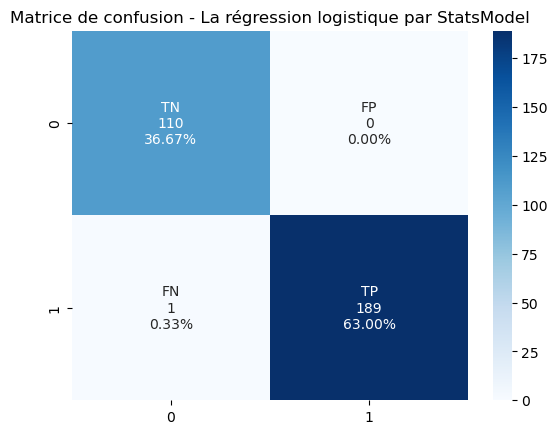

In [36]:
 y_pred = (y_prob > 0.7).astype(int)

# Arrondissez la prédiction au nombre le plus proche (0 ou 1)
prediction = list(map(round, y_pred)) 
cm = confusion_matrix(y_test, prediction)  

#Calculer précision, recall et ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# Visualiser la matrice de confusion
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Matrice de confusion - La régression logistique par StatsModel')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Test accuracy = ', accuracy_score(y_test, prediction))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

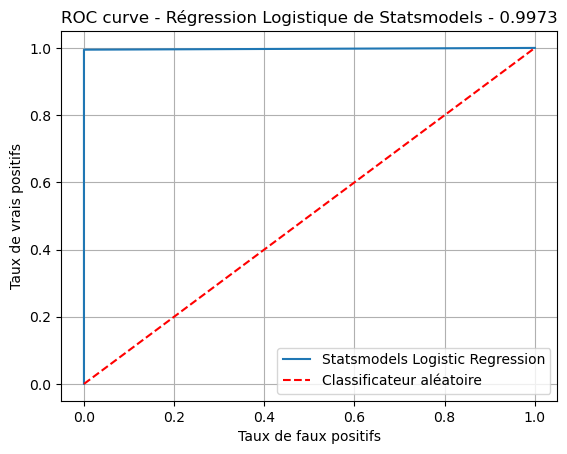

In [37]:
# Arrondissez la prédiction au nombre le plus proche (0 ou 1)
prediction = list(map(round, y_pred)) 
sm_fpr, sm_tpr, sm_thresholds = roc_curve(y_test, prediction)

# Visualiser la courbe ROC
import matplotlib.pyplot as plt
plt.plot(sm_fpr, sm_tpr, label='Statsmodels Logistic Regression')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Classificateur aléatoire')
plt.grid()
plt.title("ROC curve - Régression Logistique de Statsmodels - 0.9973")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")

plt.legend()
plt.show()

# <span style="color:blue;">2. Scikit-Learn - Régression logistique</span>

In [38]:
#Créer un scaler
scaler = StandardScaler()
billets.drop(columns='is_genuine')

# Définir les variables prédictives
X = billets.drop(columns='is_genuine')
X_scaled = scaler.fit_transform(X)
y = billets['is_genuine']

# Diviser les données en test et en train
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Trouver les valeurs les plus pertinentes

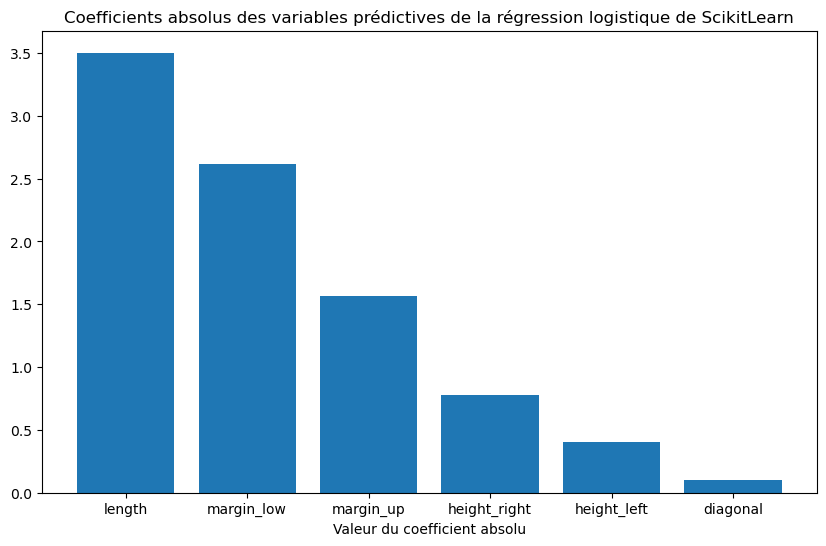

In [39]:
# Créer le modèle
sk_log_reg = LogisticRegression(random_state = 42)

# Entrainer le modele
sk_log_reg.fit(X_train, y_train)

# Trouver les coefficients pour chaque variable prédictive
coefficients = sk_log_reg.coef_[0]

# Créer un dataframe avec les variables et leurs coefficients
coefficients_df = pd.DataFrame({'Variable': billets.drop(columns='is_genuine').columns, 'Coefficient': coefficients})

# Changer les valeurs des coefficients aux valeurs absolues
coefficients_df['CoefficientMagnitude'] = abs(coefficients_df['Coefficient'])

# Trier le dataframe par ordre décroissant
coefficients_df = coefficients_df.sort_values(by='CoefficientMagnitude', ascending=False)

# Visualiser les valeurs absolues des variables
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Variable'], coefficients_df['CoefficientMagnitude'])
plt.xlabel('Valeur du coefficient absolu')
plt.title('Coefficients absolus des variables prédictives de la régression logistique de Scikit-Learn')
plt.show()

Les valeurs les plus pertinentes semble d'etre 'length', 'margin_low' et 'margin_up'

In [40]:
# Créer les étiquettes de classe prédites pour chaque billet dans X_test
y_pred = sk_log_reg.predict(X_test)

# Créer les probabilités prédites pour chaque classe pour chaque billet dans X_test
y_proba = sk_log_reg.predict_proba(X_test)


In [41]:
print('Length, margin_low, margin_up, height_right, height_left, diagonal :')
print('Accuracy =', accuracy_score(y_test, y_pred))
print("Précision =", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print("ROC AUC Score = ", roc_auc_score(y_test, y_pred))
print('---------------')

#Colonnes classées par ordre décroissant d'influence sur 'is_genuine'
del_columns = ['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']

#Noms des variables dans chaque itération
name = ['Length, margin_low, margin_up, height_right, height_left :', 
        'Length, margin_low, margin_up, height_right :',
        'Length, margin_low, margin_up:', 
        'Length, margin_low :',
        'Length :']

#Création des dataframes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Fonction pour trouver les variables les plus pertinentes pour le modèle
for col, nom in zip(del_columns, name):
    X_train_df = X_train_df.drop(columns=col)
    X_test_df = X_test_df.drop(columns=col)

    sk_log_reg.fit(X_train_df, y_train)

    y_pred = sk_log_reg.predict(X_test_df)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)    
    roc_auc = roc_auc_score(y_test, y_pred)

    print(nom)
    print('Accuracy =', acc)
    print("Précision =", precision)
    print("Recall = ", recall)
    print("ROC AUC Score = ", roc_auc)
    print('---------------')

Length, margin_low, margin_up, height_right, height_left, diagonal :
Accuracy = 0.9933333333333333
Précision = 0.9895833333333334
Recall =  1.0
ROC AUC Score =  0.9909090909090909
---------------
Length, margin_low, margin_up, height_right, height_left :
Accuracy = 0.9933333333333333
Précision = 0.9895833333333334
Recall =  1.0
ROC AUC Score =  0.9909090909090909
---------------
Length, margin_low, margin_up, height_right :
Accuracy = 0.99
Précision = 0.9844559585492227
Recall =  1.0
ROC AUC Score =  0.9863636363636364
---------------
Length, margin_low, margin_up:
Accuracy = 0.9933333333333333
Précision = 0.9895833333333334
Recall =  1.0
ROC AUC Score =  0.9909090909090909
---------------
Length, margin_low :
Accuracy = 0.9866666666666667
Précision = 0.979381443298969
Recall =  1.0
ROC AUC Score =  0.9818181818181818
---------------
Length :
Accuracy = 0.9533333333333334
Précision = 0.94
Recall =  0.9894736842105263
ROC AUC Score =  0.9401913875598086
---------------


Les trois modèles avec les meilleurs scores sont le modèle avec *length, margin_low, margin_up, height_right, height_left, et diagonal* comme variables, le modèle avec *length, margin_low, margin_up, height_right, et height_left* comme variables et le modèle avec *length, margin_low, et margin_up* comme variables.

Les trois modèles ont tous les trois les memes scores - donc je vais utiliser le modèle avec les moins de variables. Cela présente l'avantage supplémentaire de simplifier mon modèle et de réduire les risques de overfitting. Je vais donc entrainer le modèle avec ces variables.

In [42]:
# Définir les variables prédictives
X = billets[['margin_low','margin_up','length']]
y = billets['is_genuine']

# Diviser les données en test et en train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle
sk_log_reg = LogisticRegression(random_state = 42)

# Entrainer le modele
sk_log_reg.fit(X_train, y_train)

# Créer les étiquettes de classe prédites pour chaque billet dans X_test
y_pred = sk_log_reg.predict(X_test)

### Accuracy, Précision, Recall et ROC-AUC

Test accuracy =  0.99
Precision : 0.9845
Recall : 1.0000
ROC-AUC score : 0.9863636363636364


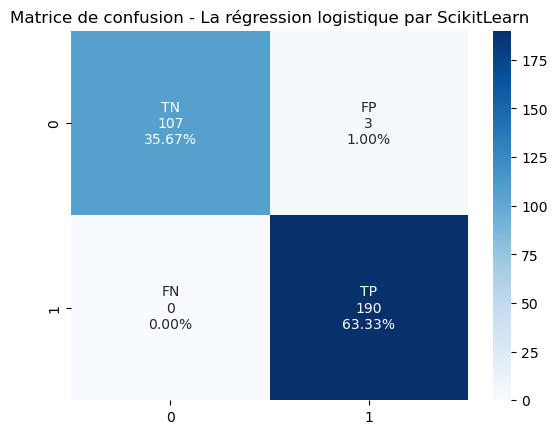

In [43]:
#Calculer précision, recall et ROC-AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Matrice de confusion 
cm = confusion_matrix(y_test, y_pred)  

# Visualiser la matrice de confusion
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Matrice de confusion - La régression logistique par Scikit-Learn')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Test accuracy = ', accuracy_score(y_test, y_pred))
print(f'Précision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

#### Accuracy
- Le modèle est précis à 99% de ses prédictions - 0.3% moins que l'accuracy du modèle de Statsmodels

#### Précision
- La précision concerne la proportion de billets qui ont été correctement identifiés comme réels. 
- Dans ce cas, 3 billets ont été identifié à tort comme étant réel alors qu’il était faux. Cela signifie que le modèle a une précision de 98,45 %.

#### Recall
- Le recall concerne la proportion de billets correctement identifiés comme faux. 
- Dans ce cas, tous les billets identifiés comme faux étaient en réalité des faux.

#### ROC-AUC
- Plus un score ROC-AUC est proche de 1, mieux c'est. Dans ce cas, le score est 0,986

Ce modèle a identifié 3 faux positifs, c'est-à-dire que 3 billets étaient étiquetés comme vrais alors qu'ils étaient faux.
Il n’a identifié aucun faux négatif.

### Amélioration du modèle - Seuil de séparation des classes

Globalement, ce sont de très bons scores. 

Cependant, la précision est adaptée pour minimiser les faux positifs, tandis que le rappel est adapté pour minimiser les faux négatifs. La précision est importante dans ce modèle, car nous voulons éviter autant que possible que de faux billets soient identifiés comme de vrais. Peut-etre je peux améliorer le score de précision?

In [44]:
# Trouver le probabilité de la classe 1
y_hat_proba = sk_log_reg.predict_proba(X_test)[:,1]

# Essayer les differents seuils
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred = [ 0 if value < threshold else 1 for value in y_hat_proba ]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print(f'Seuil {threshold} - Nombre de True Negative = {tn}')
    print(f'Seuil {threshold} - Nombre de True Positive = {tp}')
    print(f'Seuil {threshold} - Nombre de False Negative = {fn}')
    print(f'Seuil {threshold} - Nombre de False Positive = {fp}')
    print('------------------------------------------------')

Seuil 0.3 - Nombre de True Negative = 102
Seuil 0.3 - Nombre de True Positive = 190
Seuil 0.3 - Nombre de False Negative = 0
Seuil 0.3 - Nombre de False Positive = 8
------------------------------------------------
Seuil 0.4 - Nombre de True Negative = 105
Seuil 0.4 - Nombre de True Positive = 190
Seuil 0.4 - Nombre de False Negative = 0
Seuil 0.4 - Nombre de False Positive = 5
------------------------------------------------
Seuil 0.5 - Nombre de True Negative = 107
Seuil 0.5 - Nombre de True Positive = 190
Seuil 0.5 - Nombre de False Negative = 0
Seuil 0.5 - Nombre de False Positive = 3
------------------------------------------------
Seuil 0.6 - Nombre de True Negative = 108
Seuil 0.6 - Nombre de True Positive = 190
Seuil 0.6 - Nombre de False Negative = 0
Seuil 0.6 - Nombre de False Positive = 2
------------------------------------------------
Seuil 0.7 - Nombre de True Negative = 108
Seuil 0.7 - Nombre de True Positive = 190
Seuil 0.7 - Nombre de False Negative = 0
Seuil 0.7 - Nom

Un seuil de 0,6 comporte 0 faux négatif et 1 faux positif (contre 3 avec un seuil de 0,5). Je vais examiner cela plus en détail.

In [45]:
# Trouver les classes prédites pour le seuil 0.6
prediction = [0 if value < 0.6 else 1 for value in y_hat_proba]
 
# Créer la matrice de confusion
cm = confusion_matrix(y_test, prediction) 

Accuracy =  0.9933333333333333
Precision : 0.9896
Recall : 1.0000
ROC-AUC score : 0.9909090909090909


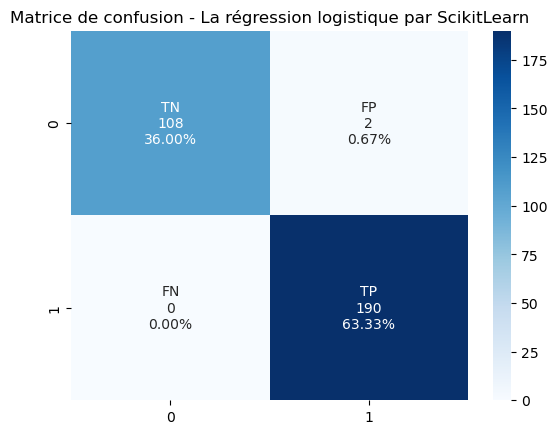

In [46]:
#Calculer précision, recall et ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# Visualiser la matrice de confusion
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Matrice de confusion - La régression logistique par Scikit-Learn')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Accuracy = ', accuracy_score(y_test, prediction))
print(f'Précision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

Le modèle de Scikit-Learn est pire que celui de Statsmodel car Statsmodel est meilleur pour identifier les faux billets de banque.

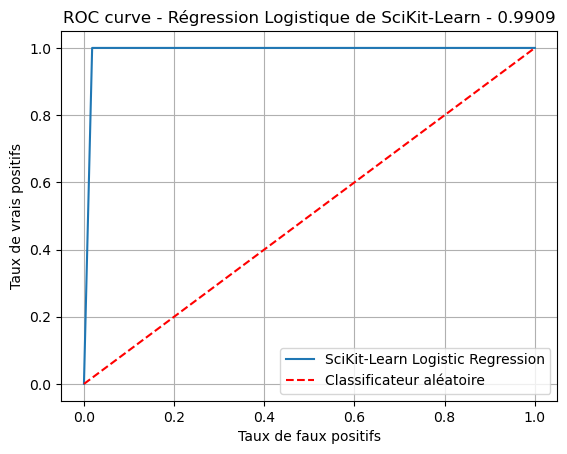

In [47]:
# Visualiser la courbe ROC
prediction = [0 if value < 0.6 else 1 for value in y_hat_proba]
sk_fpr, sk_tpr, sk_thresholds = roc_curve(y_test, prediction)
plt.plot(sk_fpr, sk_tpr, label='Régression logistique SciKit-Learn')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Classificateur aléatoire')
plt.grid()
plt.title("Courbe ROC - Régression Logistique de SciKit-Learn - 0.9909")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")

plt.legend()
plt.show()

## La mèthode k-means

Je vais maintenant créer un modèle k-means et le comparer aux 2 régressions logistiques.

In [48]:
# Normaliser et définir les variables prédictives
X = billets[['diagonal','height_left','height_right','margin_low','margin_up','length']]

#Instancier le scaler
std_scale = preprocessing.StandardScaler()

#Entrainer le scaler
std_scale.fit(X)

#Transformer les données
X_scaled = std_scale.transform(X)

# Définir la variable cible
y= billets.is_genuine.values

# Diviser les données en test et en train
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

Avec ce projet, je n'ai pas besoin d'utiliser la méthode du coude, parce que je sais que je veux trouver deux clusters - un pour les vrais billets et un pour les faux billets. 

In [49]:
# Créer un k-means avec 2 clusters
kmeans = KMeans(n_clusters=2,n_init=10, random_state=42)

# Entrainer le k-means avec X_train 
kmeans.fit(X_scaled)

# Stocker les labels dans la variable 'labels'
labels = kmeans.labels_ + 1

# Stocker les centroids dans la variable 'centroids' 
centroids = kmeans.cluster_centers_

In [50]:
#Créez une ACP et l'entrainez
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [51]:
#Projettez les points dans le nouvel espace
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2"])
X_proj[:10]

PC1       PC2
0  1.647277  0.747301
1 -2.019805 -2.206729
2 -0.969101  2.619251
3 -1.375780 -1.817566
4  0.150302 -0.566044
5 -0.695930  0.426945
6  0.176100  1.302713
7 -1.151185 -0.382759
8 -0.854144  1.443684
9 -0.596853  1.743484

In [52]:
# Utilisez le scaler avec les centroids 
centroids_scaled = scaler.fit_transform(centroids)

# Utilisez l'ACP avec les centroids
centroids_proj = pca.transform(centroids_scaled)

# Créez un dataframe avec les centroids_proj
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns = ["F1", "F2"], 
                              index=["cluster_0", "cluster_1"])

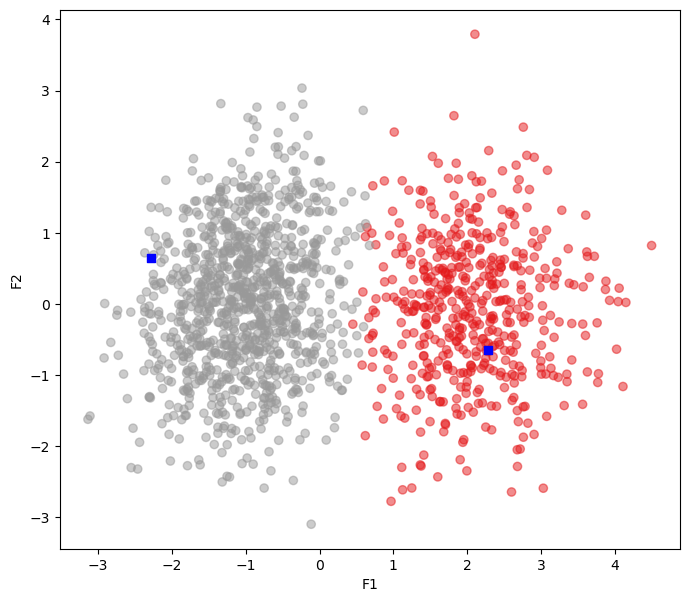

In [53]:
# Créez le scatterplot avec des centroids
#Definez le figure et son axe
fig, ax = plt.subplots(1,1, figsize=(8,7))

# Affichez lesindividus, avec une transparence de 50% 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# Affichez les centroides, en bleue et avec une forme de carré
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s", c="blue" )

# Créez la graphique
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

In [54]:
# Créer un k-means avec 2 clusters et avec un random_state de 2 afin d'etre sur 
# que les clusters faire correspondre les valeurs 0 et 1 des billets
kmeans = KMeans(n_clusters=2,n_init=10, random_state=2)

# Entrainer le k-means avec X_train 
kmeans.fit(X_train)

KMeans(n_clusters=2, n_init=10, random_state=2)

Je vais prédire si un billet est vrai ou faux, en fonction du centroïde le plus proche du billet.

In [55]:
y_pred = kmeans.predict(X_test)

# Arrondissez la prédiction au nombre le plus proche (0 ou 1)
prediction = list(map(round, y_pred)) 
 
# Créer une matrice de confusion
cm = confusion_matrix(y_test, prediction) 

Accuracy =  0.9866666666666667
Precision : 0.9949
Recall : 0.9848
ROC-AUC score : 0.9875222816399287


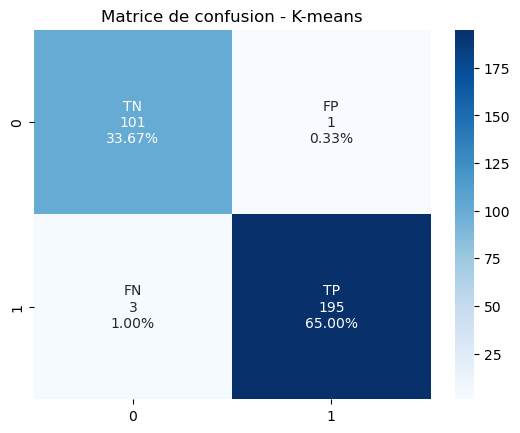

In [56]:
#Calculer précision, recall et ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# Visualiser la matrice de confusion
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Matrice de confusion - K-means')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Accuracy = ', accuracy_score(y_test, prediction))
print(f'Précision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

Ce modèle est pire que les modèles de régression logistique.

#### Accuracy
- Le modèle est précis à 98,6% de ses prédictions

#### Précision
- La précision concerne la proportion de billets qui ont été correctement identifiés comme réels. 
- Dans ce cas, 4 billets ont été identifié à tort comme étant réel alors qu’il était faux. Cela signifie que le modèle a une précision de 98,02 %.

#### Recall
- Le recall concerne la proportion de billets correctement identifiés comme faux. 
- Dans ce cas, tous les billets identifiés comme faux étaient en réalité des faux.

#### ROC-AUC
- Plus un score ROC-AUC est proche de 1, mieux c'est. Dans ce cas, le score est 0,98

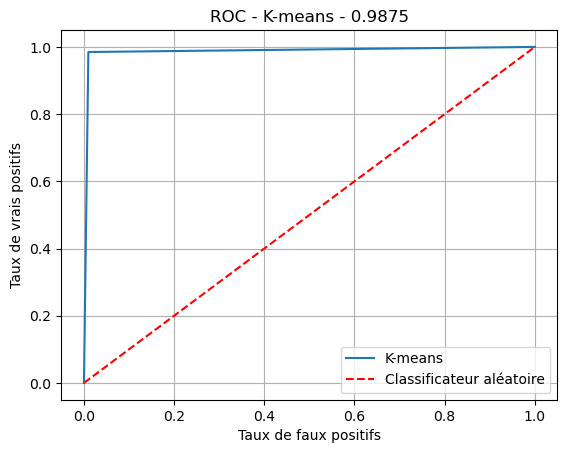

In [57]:
prediction = kmeans.predict(X_test)
km_fpr, km_tpr, km_thresholds = roc_curve(y_test, prediction)

# Visualiser la courbe ROC
import matplotlib.pyplot as plt
plt.plot(km_fpr, km_tpr, label='K-means')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Classificateur aléatoire')
plt.grid()
plt.title("ROC - K-means - 0.9875")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")

plt.legend()
plt.show()

# Conclusions

In [58]:
# Scikit-Learn LOGREG
# Définir les variables prédictives
X = billets[['margin_low','margin_up','length']]
y = billets['is_genuine']
# Diviser les données en test et en train
sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sk_log_reg = sk_log_reg.fit(sk_X_train, sk_y_train)

y_hat_proba = sk_log_reg.predict_proba(sk_X_test)[:,1]

sk_prediction = [0 if value < 0.6 else 1 for value in y_hat_proba]
              
sk_fpr, sk_tpr, sk_thresholds = roc_curve(sk_y_test, sk_prediction)



In [59]:
# STATSMODELS LOGREG
# Définir les variables prédictives
X = billets[['height_right','margin_low','margin_up','length']]
# Diviser les données en test et en train
sm_X_train, sm_X_test, sm_y_train, sm_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm_log_reg = sm.Logit(sm_y_train, sm_X_train).fit()

y_prob = sm_log_reg.predict(sm_X_test)

y_pred = (y_prob > 0.7).astype(int)

# Arrondissez la prédiction au nombre le plus proche (0 ou 1)
sm_prediction = list(map(round, y_pred)) 
sm_fpr, sm_tpr, sm_thresholds = roc_curve(sm_y_test, sm_prediction)

Optimization terminated successfully.
         Current function value: 0.030209
         Iterations 11


In [60]:
# K-MEANS
# Définir les variables prédictives
X = billets[['diagonal','height_left','height_right','margin_low','margin_up','length']]
# Diviser les données en test et en train
km_X_train, km_X_test, km_y_train, km_y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Créer un k-means avec 2 clusters
kmeans = KMeans(n_clusters=2,n_init=10, random_state=2)

# Entrainer le k-means avec X_train 
kmeans.fit(km_X_train)

km_prediction = kmeans.predict(km_X_test)
km_fpr, km_tpr, km_thresholds = roc_curve(km_y_test, km_prediction)

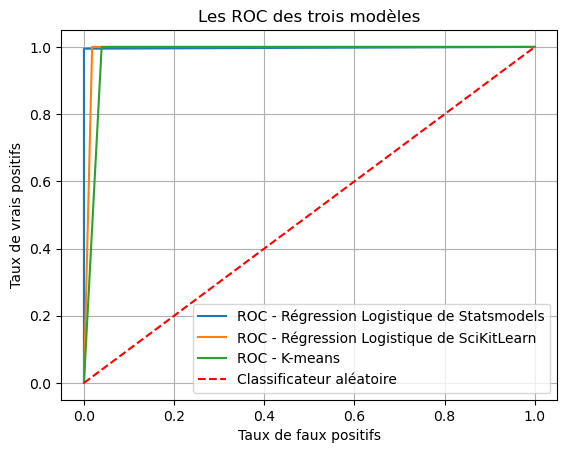

In [61]:
# Visualiser les courbes ROC

plt.plot(sm_fpr, sm_tpr, label='ROC - Régression Logistique de Statsmodels')
plt.plot(sk_fpr, sk_tpr, label='ROC - Régression Logistique de Scikit-Learn')
plt.plot(km_fpr, km_tpr, label='ROC - K-means')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Classificateur aléatoire')
plt.legend()
plt.grid()
plt.title("Les ROC des trois modèles")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")

plt.show()

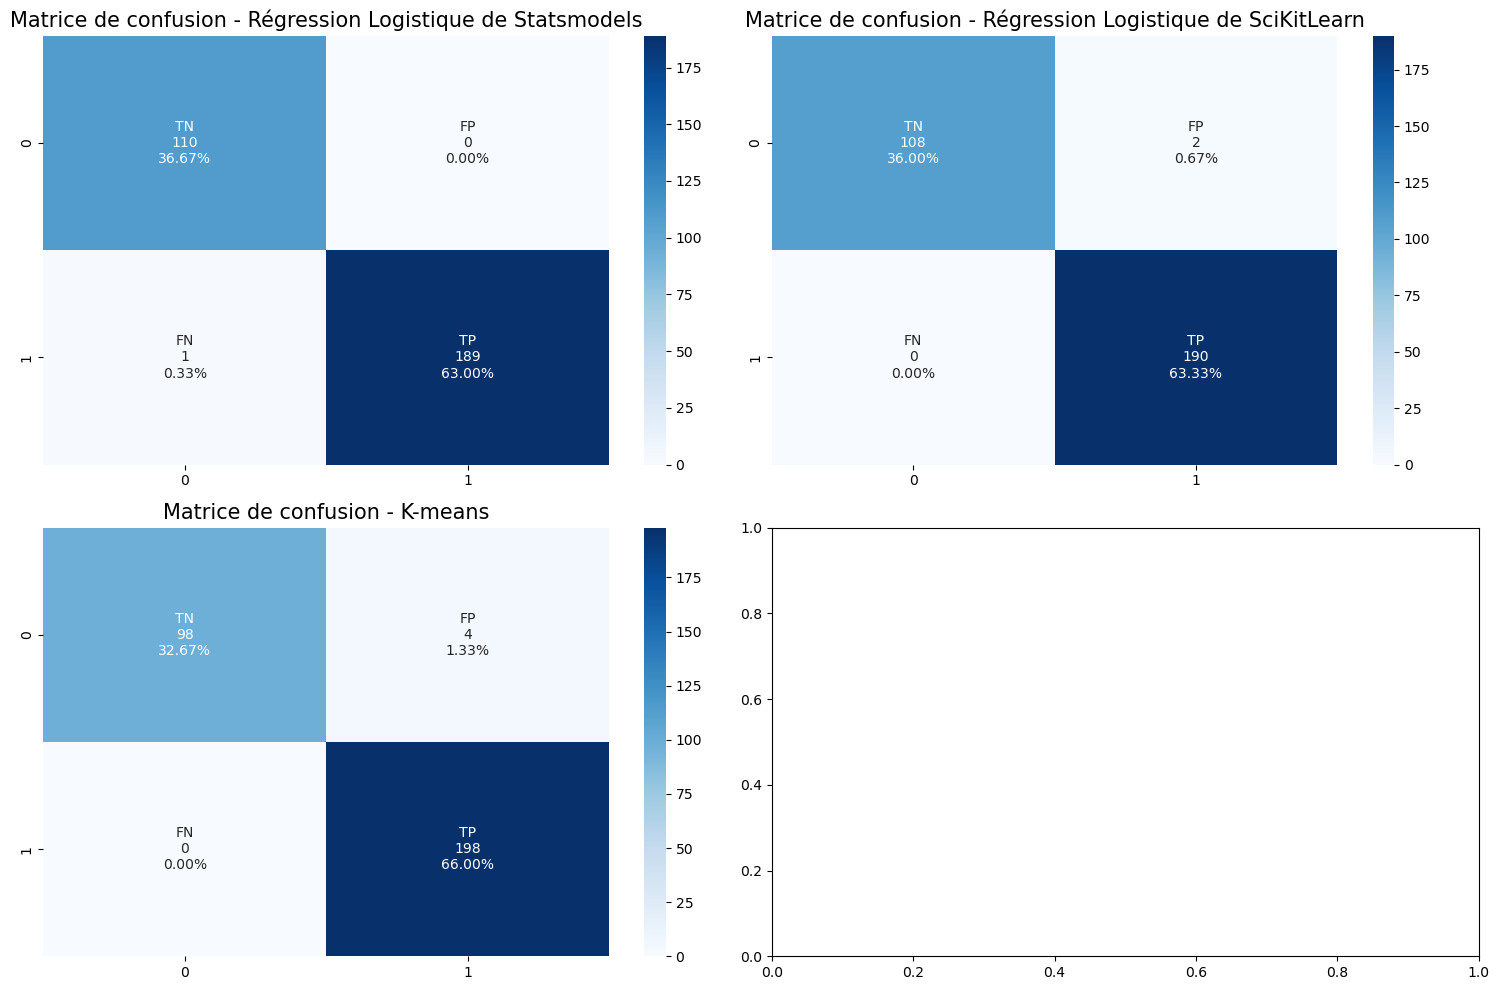

In [62]:
cm_values = [{'y_test': sm_y_test, 'prediction': sm_prediction}, {'y_test': sk_y_test, 'prediction': sk_prediction},{'y_test': km_y_test, 'prediction': km_prediction}]
names = ['Régression Logistique de Statsmodels', 'Régression Logistique de Scikit-Learn', 'K-means']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, cm_value) in enumerate(zip(names, cm_values)):
    cm = confusion_matrix(cm_value['y_test'], cm_value['prediction'])
    ax = axes[i]
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    ax.set_title(f'Matrice de confusion - {name}', size=15)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax)

plt.tight_layout()
plt.show()

In [63]:
analyse_values = [{'y_test': sm_y_test, 'prediction': sm_prediction}, {'y_test': sk_y_test, 'prediction': sk_prediction},{'y_test': km_y_test, 'prediction': km_prediction}]
names = ['Régression Logistique de Statsmodels', 'Régression Logistique de Scikit-Learn', 'K-means']

for (name, analyse_value) in (zip(names, analyse_values)):
    print(name)
    print('Accuracy = ', accuracy_score(analyse_value['y_test'], analyse_value['prediction']))
    print('Précision = ', precision_score(analyse_value['y_test'], analyse_value['prediction']))
    print('Recall = ', recall_score(analyse_value['y_test'], analyse_value['prediction']))
    print('ROC-AUC = ', roc_auc_score(analyse_value['y_test'], analyse_value['prediction']))
    print('------------------------------------------------------')

Régression Logistique de Statsmodels
Accuracy =  0.9966666666666667
Precision =  1.0
Recall =  0.9947368421052631
ROC-AUC =  0.9973684210526316
------------------------------------------------------
Régression Logistique de SciKitLearn
Accuracy =  0.9933333333333333
Precision =  0.9895833333333334
Recall =  1.0
ROC-AUC =  0.9909090909090909
------------------------------------------------------
K-means
Accuracy =  0.9866666666666667
Precision =  0.9801980198019802
Recall =  1.0
ROC-AUC =  0.9803921568627452
------------------------------------------------------


#### Conclusions :
- Le meilleur modèle est la régression logistique de Statsmodels :
    - Le meilleur score d’accuracy
    - Le meilleur score de précision
    - Le meilleur score de ROC-AUC
    - Malgré un faux négatif, ce modèle offre les meilleures capacités de prédiction.
 
- Le modèle le moins efficace est la méthode des k-means. Les scores de ROC-AUC, accuracy et pr"cision sont tous les pires scores des 3 modèles.

# Analyse prédictive

In [64]:
# Définir les variables prédictives
X = billets[['height_right','margin_low','margin_up','length']]
y = billets.is_genuine

# Diviser les données en test et en train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrainer le modèle
sm_log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.030209
         Iterations 11


In [69]:
files = ['billets_production.csv']

for file in files:
    valeurs_soutenance = pd.read_csv(file)
    valeurs_à_prédire = valeurs_soutenance[['height_right','margin_low','margin_up','length']]
    y_prob = sm_log_reg.predict(valeurs_à_prédire)
    y_pred = (y_prob > 0.7).astype(int)
    prediction = list(map(round, y_pred))
    result_df = pd.DataFrame({'ID': valeurs_soutenance['id'],'Predicted': prediction, 'y prob': y_prob})
    result_df.loc[result_df['Predicted']==0, 'Predicted']='Faux'
    result_df.loc[result_df['Predicted']==1, 'Predicted']='Vrai'

display(result_df)

ID Predicted    y prob
0  A_1      Faux  0.000499
1  A_2      Faux  0.000009
2  A_3      Faux  0.000039
3  A_4      Vrai  0.987140
4  A_5      Vrai  0.999989